In [1]:
import jax

import jax.numpy as np
import jax.scipy as sp

import scipy as osp
from scipy.stats import kde

from numpy.polynomial.hermite import hermgauss

import paragami

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['axes.titlesize'] = 18

from bnpmodeling_runjingdev import cluster_quantities_lib, result_loading_utils

from structure_vb_lib import structure_model_lib, posterior_quantities_lib, plotting_utils
from structure_vb_lib.data_utils import cluster_admix_get_indx_within_labels, load_thrush_data

from copy import deepcopy

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
import numpy as onp 
onp.random.seed(53453)

# File paths

In [3]:
data_file = '../data/thrush_data/thrush-data.str'
out_filename = 'thrush_fit'
out_folder = '../fits/thrush_fits/'

In [4]:
alpha0 = 3.0

In [5]:
# class with method to load all files from a particular perturbation
result_loader = result_loading_utils.FunctionalRefitsLoader(alpha0, 
                                                            out_folder, 
                                                            out_filename)

loading initial fit from:  ../fits/thrush_fits/thrush_fit_alpha3.0.npz
loading lr derivatives from:  ../fits/thrush_fits/thrush_fit_alpha3.0_lrderivatives.npz


# Load data

In [6]:
g_obs, _, labels, _ = load_thrush_data(data_file)

loading thrush data from : 
../data/thrush_data/thrush-data.str


In [7]:
n_obs = g_obs.shape[0]
n_loci = g_obs.shape[1]
n_allele = g_obs.shape[-1]

# Load initial fit and other model parameters

In [8]:
vb_init_free = result_loader.vb_init_free
vb_params_paragami = result_loader.vb_params_paragami
vb_init_dict = vb_params_paragami.fold(vb_init_free, free = True)

In [9]:
vb_init_free = vb_params_paragami.flatten(vb_init_dict, free = True)

In [10]:
# gauss-hermite parameters
gh_deg = int(result_loader.init_fit_meta_data['gh_deg'])
gh_loc, gh_weights = hermgauss(gh_deg)

gh_loc = np.array(gh_loc)
gh_weights = np.array(gh_weights)
    
# load prior parameters
prior_params_dict, prior_params_paragami = \
    structure_model_lib.get_default_prior_params(n_allele)

# set initial alpha
assert alpha0 == result_loader.init_fit_meta_data['dp_prior_alpha']
prior_params_dict['dp_prior_alpha'] = alpha0

print(prior_params_dict)


{'dp_prior_alpha': 3.0, 'allele_prior_lambda_vec': DeviceArray([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
             1., 1., 1., 1., 1., 1.], dtype=float64)}


# Function to get posterior statistics

In [11]:
def get_e_ind_admix(vb_free_params): 
    
    # this returns the expected individual mixture proportions. 

    vb_params_dict = vb_params_paragami.fold(vb_free_params, free = True)
    
    stick_means = vb_params_dict['ind_admix_params']['stick_means']
    stick_infos = vb_params_dict['ind_admix_params']['stick_infos']
    
    e_ind_admix = cluster_quantities_lib.get_e_cluster_probabilities(stick_means, 
                                                                     stick_infos, 
                                                                     gh_loc, 
                                                                     gh_weights)
    return e_ind_admix

### Plot initial fit

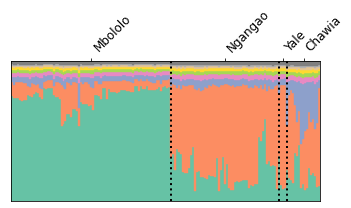

In [32]:
e_ind_admix_init = get_e_ind_admix(vb_init_free)

# sort everything within populations
perm_obs = cluster_admix_get_indx_within_labels(onp.array(e_ind_admix_init),
                                                labels)

# now re-order populations: put chawia last
_labels = deepcopy(labels)
_labels[_labels == 'Chawia'] = 'z'
perm2 = onp.argsort(_labels)
perm_obs = perm_obs[perm2]

# plot admixture
fig, ax = plt.subplots(1, 1, figsize = (5, 3))

plotting_utils.plot_top_clusters(onp.array(e_ind_admix_init)[perm_obs], 
                                 ax,
                                 8, 
                                 cmap_colors = plt.get_cmap('Set2').colors);

# print labels
plotting_utils.draw_region_separation(labels[perm2], ax);

fig.tight_layout();
fig.savefig('../../writing/notes_for_tamara/figures/structure_init_admixture.png')

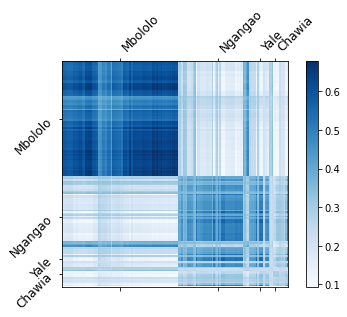

In [13]:
coclust = np.dot(e_ind_admix_init[perm_obs], 
                 e_ind_admix_init[perm_obs].transpose())

fig, ax = plt.subplots(1, 1, figsize = (6, 4.5))

im0 = ax.matshow(coclust, 
                 cmap = plt.get_cmap('Blues'))

ax.set_xticks([])
ax.set_yticks([])

fig.colorbar(im0, ax = ax)

plotting_utils.draw_regions_on_coclust(labels[perm2], ax, draw_lines = False)

fig.tight_layout();

fig.savefig('../../writing/notes_for_tamara/figures/structure_init_coclust.png')

### Plot co-clustering

In [14]:
def plot_coclustering(e_ind_admix_refit, e_ind_admix_lr, e_ind_admix_init, fig, ax): 
        
    # compute co-clustering matrix 
    coclust_init = np.dot(e_ind_admix_init, 
                          e_ind_admix_init.transpose())
    coclust_refit = np.dot(e_ind_admix_refit,
                           e_ind_admix_refit.transpose())
    coclust_lr = np.dot(e_ind_admix_lr,
                        e_ind_admix_lr.transpose())
    
    
    # plot diff colormaps
    result_loading_utils.plot_colormaps(coclust_refit,
                                        coclust_lr,
                                        coclust_init,
                                        fig, ax[1:],
                                        plot_initial = False)
    
    # plot diff in expected individual belongings
#     result_loading_utils.print_diff_plot(e_ind_admix_refit.flatten(), 
#                                          e_ind_admix_lr.flatten(),
#                                          e_ind_admix_init.flatten(), 
#                                          ax[1],
#                                          alpha = 0.05)
    
    
    # plot diff in coclustering
    result_loading_utils.print_diff_plot(coclust_refit.flatten(), 
                                         coclust_lr.flatten(),
                                         coclust_init.flatten(), 
                                         ax[0],
                                         alpha = 0.01, 
                                         plot_contours = True)

        
    return fig, ax

### Function to make trace plots

In [15]:
@jax.jit
def get_diff_in_e_ind_admix(vb_free): 
    vb_params_dict = vb_params_paragami.fold(vb_free, free = True)
    e_ind_admix = get_e_ind_admix(vb_free)
    
    e_ind_admix0 = get_e_ind_admix(vb_init_free)
    
    return np.abs(e_ind_admix - e_ind_admix0).mean()

In [16]:
@jax.jit
def get_diff_in_coclustering(vb_free): 
    vb_params_dict = vb_params_paragami.fold(vb_free, free = True)
    e_ind_admix = get_e_ind_admix(vb_free)
    coclust_matr = np.dot(e_ind_admix, e_ind_admix.transpose())
    
    e_ind_admix0 = get_e_ind_admix(vb_init_free)
    coclust_matr0 = np.dot(e_ind_admix0, e_ind_admix0.transpose())
    
    return np.abs(coclust_matr - coclust_matr0).mean()

### Function to plot all results

In [17]:
# def plot_results_for_perturbation(perturbation, delta, epsilon_indx_vec = [-1]): 
#     #################
#     # load free parameters
#     #################
#     vb_refit_list, lr_list, epsilon_vec = \
#         result_loader.get_free_param_results_from_perturbation(perturbation, delta)
    
#     assert (vb_refit_list[0] == lr_list[0]).all()
    
#     #################
#     # see how our summary statistic changes
#     #################
#     fig, ax = plt.subplots(1, 3, figsize = (12, 3))
#     result_loading_utils.plot_post_stat_per_epsilon(get_diff_in_e_ind_admix, 
#                                                     vb_refit_list,
#                                                     lr_list,
#                                                     epsilon_vec,
#                                                     ax[0])
#     ax[0].set_ylabel('median. abs. error in ez')
    
#     result_loading_utils.plot_post_stat_per_epsilon(get_diff_in_coclustering, 
#                                                     vb_refit_list,
#                                                     lr_list,
#                                                     epsilon_vec,
#                                                     ax[1])
#     ax[1].set_ylabel('median. abs. error in coclust')
#     ax[0].legend()
    
#     for a in ax[0:2]: 
#         for eps_indx in epsilon_indx_vec: 
#             a.axvline(epsilon_vec[eps_indx],
#                        color = 'grey',
#                        linestyle = 'dashed')
#     fig.tight_layout()

#     ###############
#     # initial admixture and coclustering
#     ###############
#     coclust_init = np.dot(e_ind_admix_init[perm_obs], 
#                           e_ind_admix_init[perm_obs].transpose())
#     ax[2].set_title('initial coclustering')
#     im0 = ax[2].matshow(coclust_init, 
#                         cmap = plt.get_cmap('Blues'))
#     fig.colorbar(im0, ax = ax[2])

#     for eps_indx in epsilon_indx_vec: 
#         #################
#         # get admixtures
#         #################
#         e_ind_admix_refit = get_e_ind_admix(vb_refit_list[eps_indx])
#         e_ind_admix_lr = get_e_ind_admix(lr_list[eps_indx])

#         #####################
#         # plot co-clustering
#         #####################
#         fig, ax = plot_coclustering(e_ind_admix_refit[perm_obs], 
#                                     e_ind_admix_lr[perm_obs],
#                                     e_ind_admix_init[perm_obs])
#         ax[0].set_title('diff in ez; epsilon = {:.03f}'.format(epsilon_vec[eps_indx]))
#         ax[1].set_title('diff in coclust; epsilon = {:.03f}'.format(epsilon_vec[eps_indx]))
    
#         fig.tight_layout()

In [18]:
def plot_results_for_perturbation(perturbation, delta, epsilon_indx_vec = [-1]): 
    #################
    # load free parameters
    #################
    vb_refit_list, lr_list, epsilon_vec = \
        result_loader.get_free_param_results_from_perturbation(perturbation, delta)
    
    assert (vb_refit_list[0] == lr_list[0]).all()
    
    
    fig, ax = plt.subplots(4, 4, figsize = (18, 16))
    
    #################
    # Plot perturbation
    #################
    result_loading_utils.plot_perturbation(perturbation, delta, alpha0, 
                                           ax = ax[0])

    ###############
    # initial admixture and coclustering
    ###############
    coclust_init = np.dot(e_ind_admix_init[perm_obs], 
                          e_ind_admix_init[perm_obs].transpose())

    i = 1
    for eps_indx in epsilon_indx_vec: 
        #################
        # get admixtures
        #################
        e_ind_admix_refit = get_e_ind_admix(vb_refit_list[eps_indx])
        e_ind_admix_lr = get_e_ind_admix(lr_list[eps_indx])

        #####################
        # plot co-clustering
        #####################
        plot_coclustering(e_ind_admix_refit[perm_obs], 
                          e_ind_admix_lr[perm_obs],
                          e_ind_admix_init[perm_obs], 
                          fig, ax[i])
        
        i += 1
    
    
    # some cleaning of labels
    for i in range(1, len(epsilon_indx_vec)+1): 
        
        eps = epsilon_vec[epsilon_indx_vec[i-1]] 
        
        for j in range(1, 3): 
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
        
        ax[i, 0].set_title('Diff co-clust; epsilon = {:.02f}'.format(eps),
                           fontsize = 20)

        if i == 1: 
            ax[i, 1].set_title('refit - init', fontsize = 20)
            ax[i, 2].set_title('lr - init', fontsize = 20)
        else: 
            ax[i, 1].set_title('', fontsize = 20)
            ax[i, 2].set_title('', fontsize = 20)
            
        ax[i, 3].set_visible(False)

    
    fig.tight_layout()
    
    fig.savefig('../../writing/notes_for_tamara/figures/structure_' + perturbation + '_delta' + str(delta) + '_coclustering.png')
    

# Plot results

# Sigmoidal perturbations

Optim time at epsilon = 1: 7.218secs
Derivative time: 0.699secs


/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 1.300350e-07
  warnings.warn(


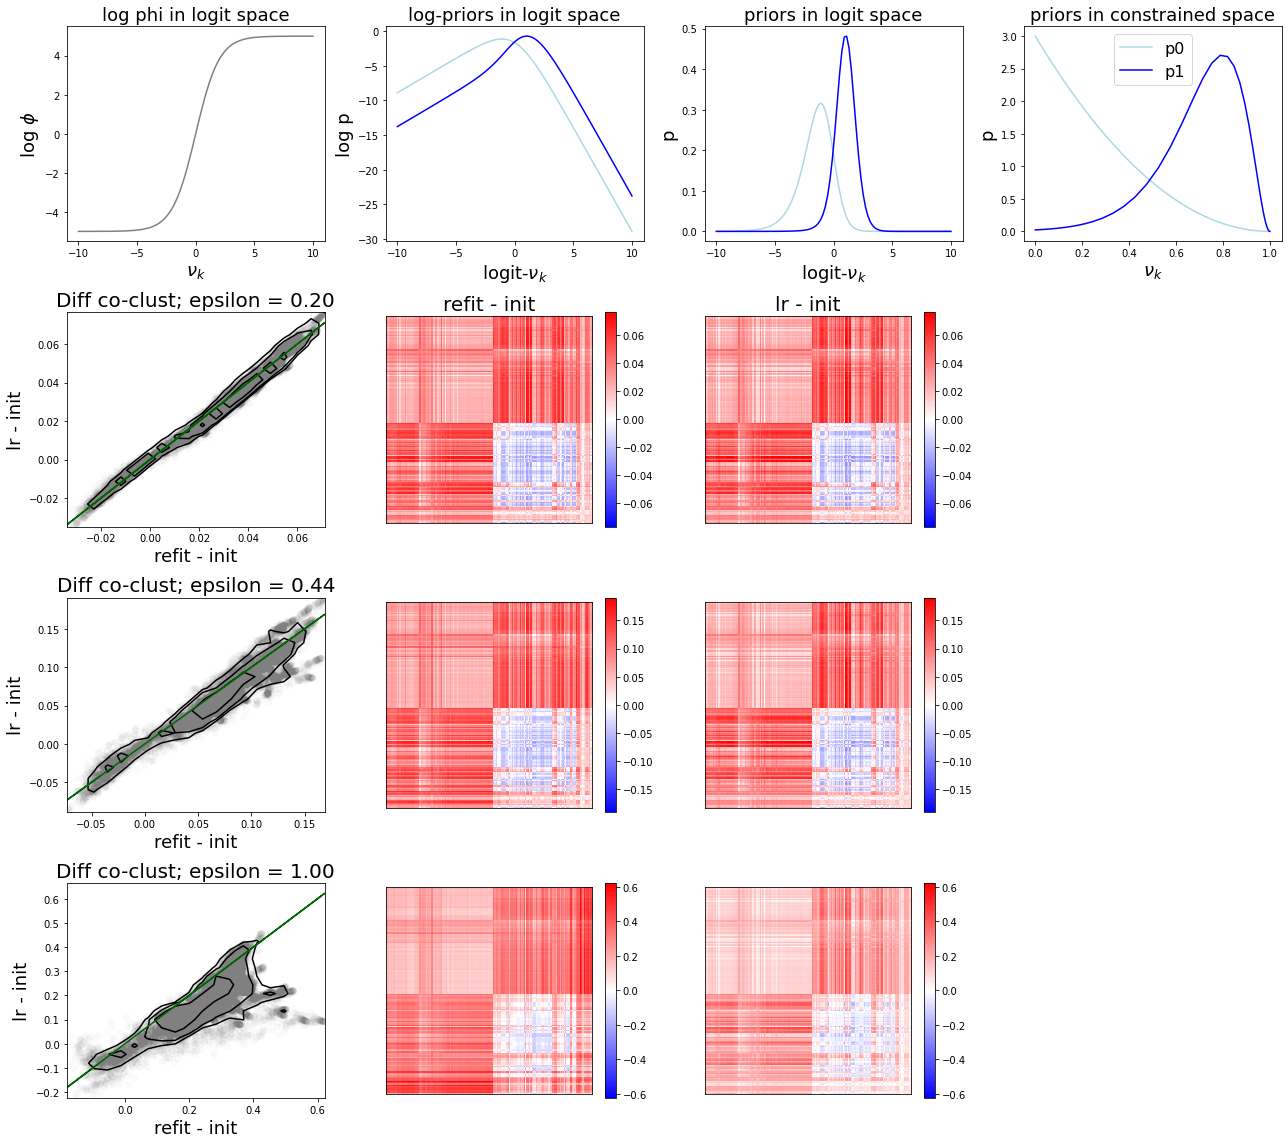

In [19]:
perturbation = 'sigmoidal'
delta = 5
plot_results_for_perturbation(perturbation, delta, epsilon_indx_vec = [4, 6, -1])

Optim time at epsilon = 1: 12.411secs
Derivative time: 0.699secs


/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 6.735899e-07
  warnings.warn(


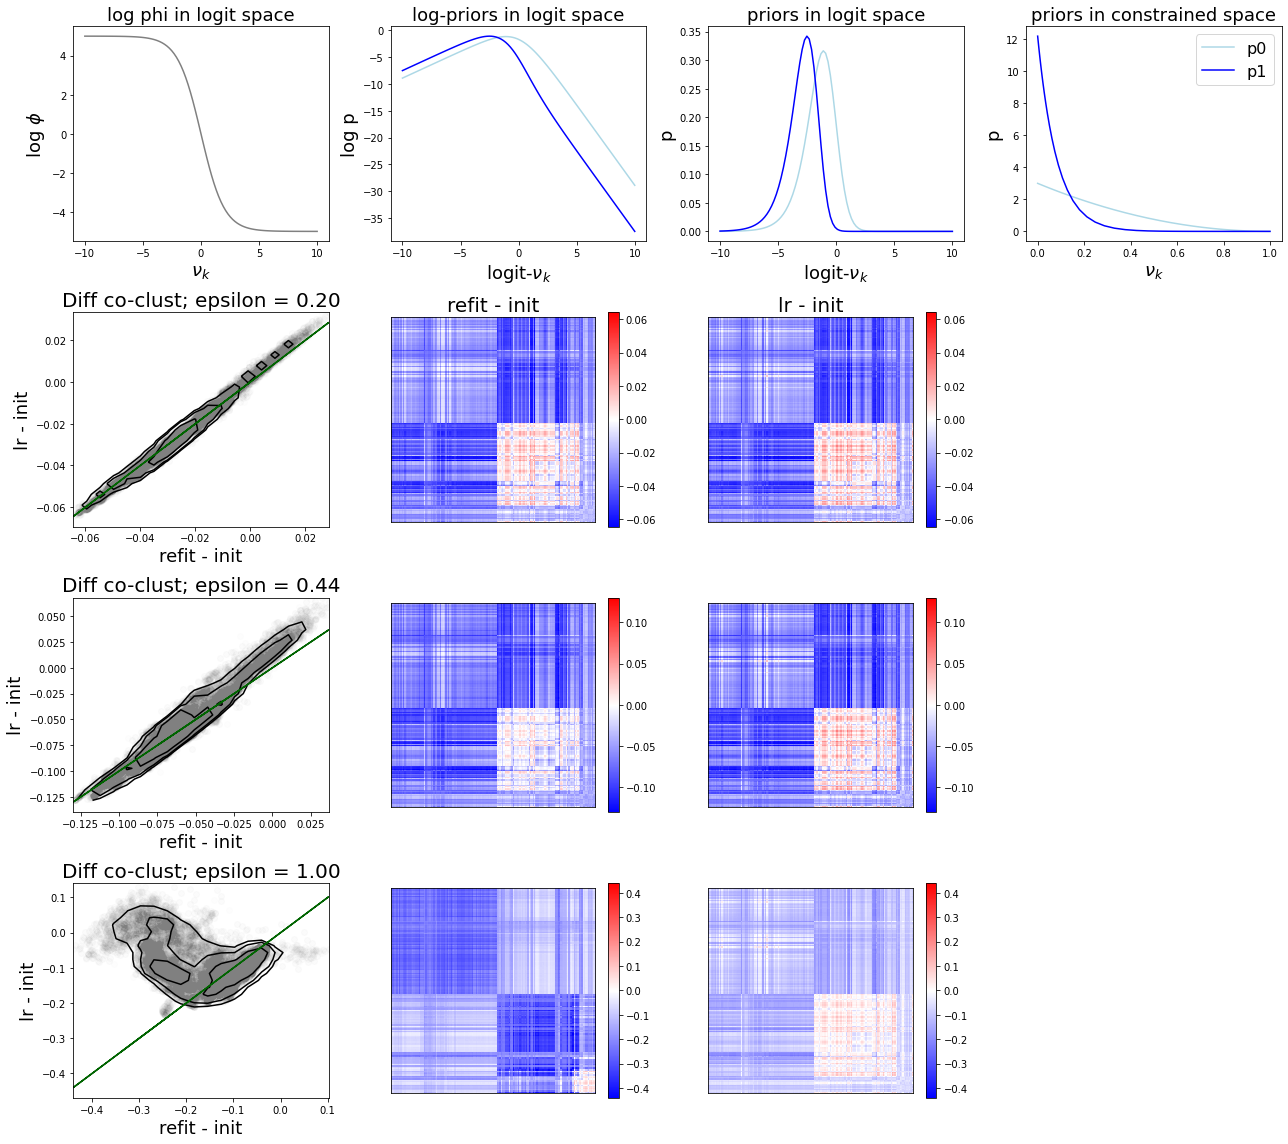

In [29]:
perturbation = 'sigmoidal'
delta = -5
# result_loading_utils.plot_perturbation(perturbation, delta, alpha0)

plot_results_for_perturbation(perturbation, delta, epsilon_indx_vec = [4, 6, -1])

# Perturbations corresponding to moving \alpha

Optim time at epsilon = 1: 7.334secs
Derivative time: 0.669secs


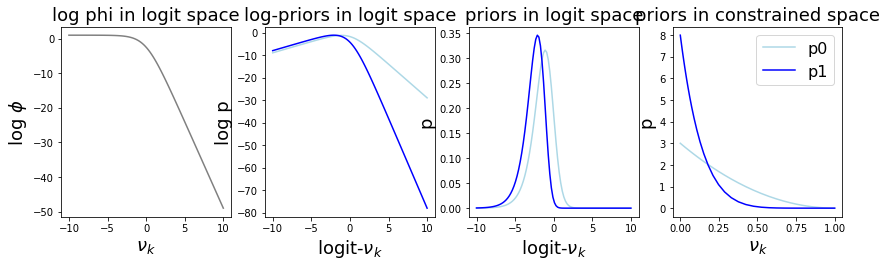

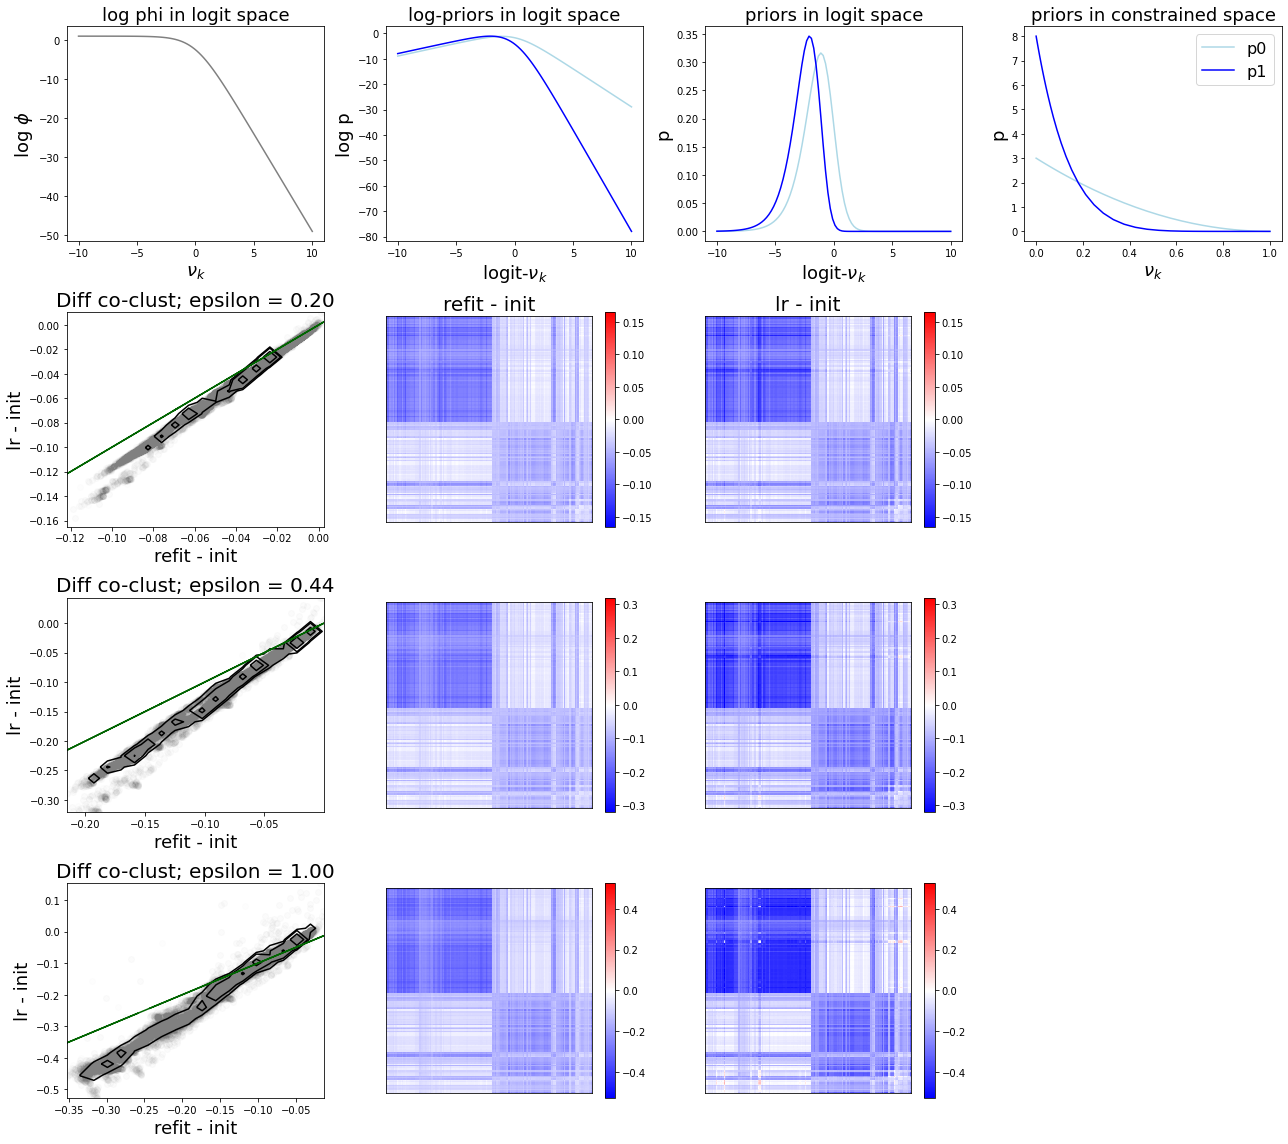

In [21]:
perturbation = 'alpha_pert_pos'
delta = 1
result_loading_utils.plot_perturbation(perturbation, delta, alpha0)
plot_results_for_perturbation(perturbation, delta, epsilon_indx_vec = [4, 6, -1])

In [22]:
# perturbation = 'alpha_pert_neg'
# delta = 1
# result_loading_utils.plot_perturbation(perturbation, delta, alpha0)
# plot_results_for_perturbation(perturbation, delta, epsilon_indx_vec = [4, 6, -1])

In [23]:
# perturbation = 'alpha_pert_pos_xflip'
# plot_perturbation(perturbation, delta = 1)
# plot_results_for_perturbation(perturbation, delta = 1)

In [24]:
# perturbation = 'alpha_pert_neg_xflip'
# plot_perturbation(perturbation)
# plot_results_for_perturbation(perturbation)

# Gaussian perturbations

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 1.453183e-06
  warnings.warn(


Optim time at epsilon = 1: 6.238secs
Derivative time: 0.715secs


/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 1.453183e-06
  warnings.warn(


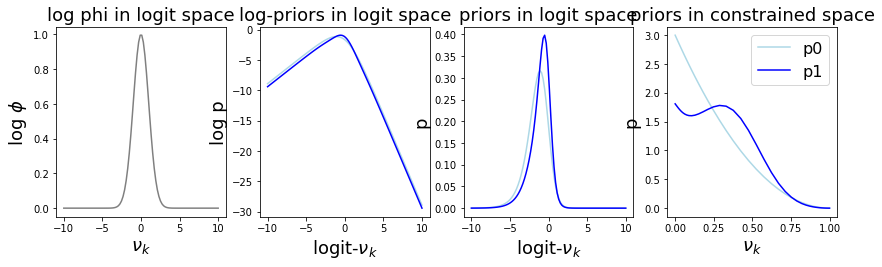

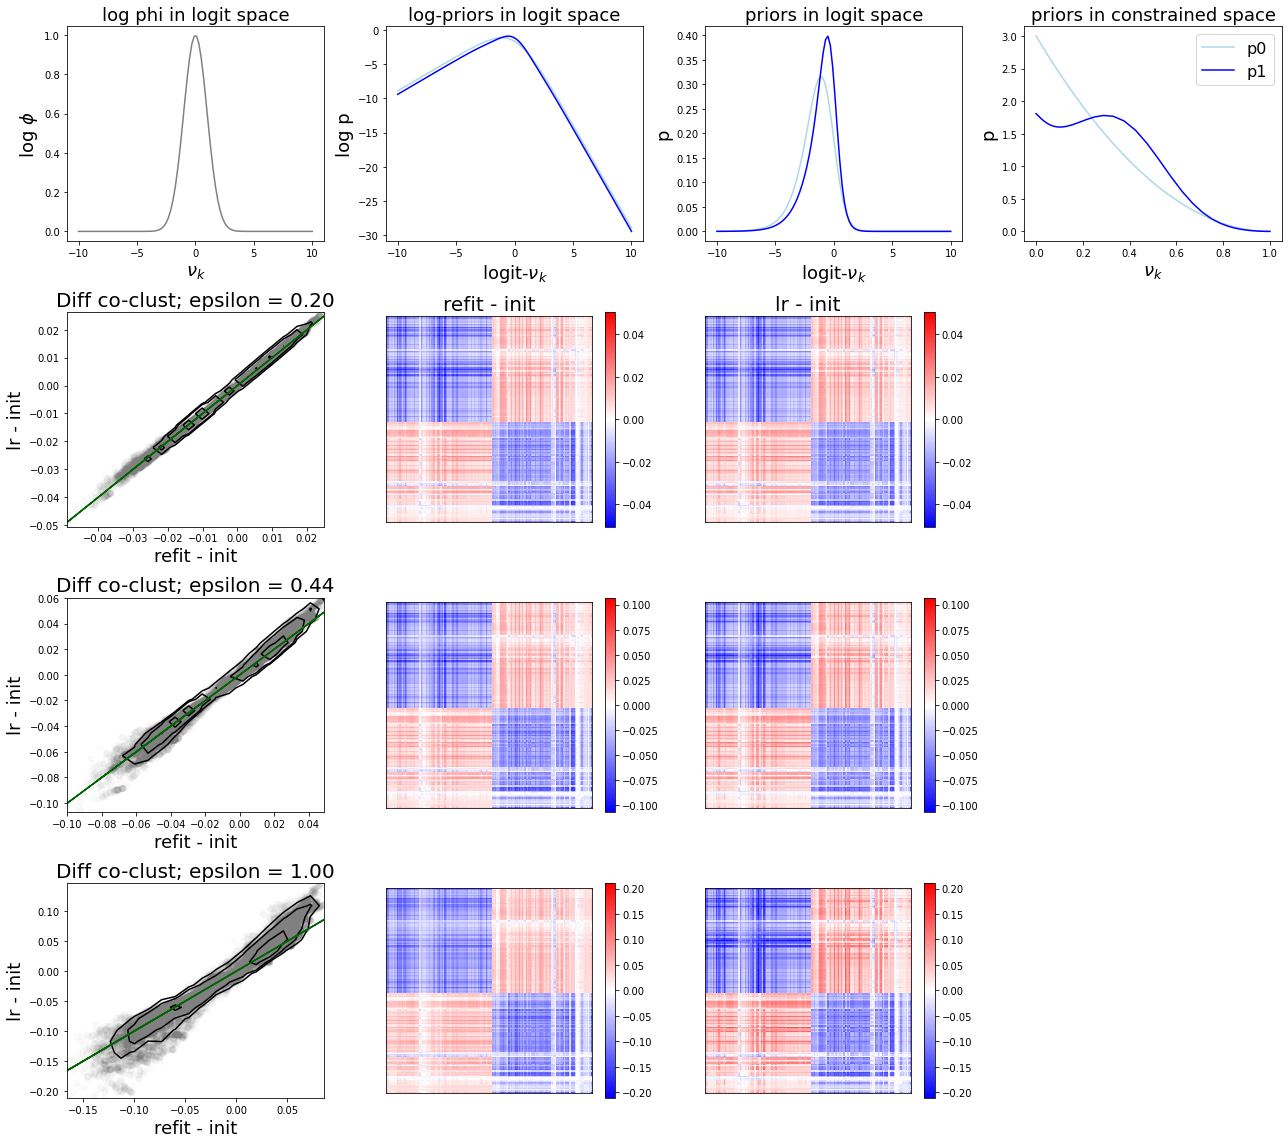

In [25]:
perturbation = 'gauss_pert1'
delta = 1
result_loading_utils.plot_perturbation(perturbation, delta, alpha0)
plot_results_for_perturbation(perturbation, delta, epsilon_indx_vec = [4, 6, -1])

Optim time at epsilon = 1: 8.320secs
Derivative time: 0.715secs


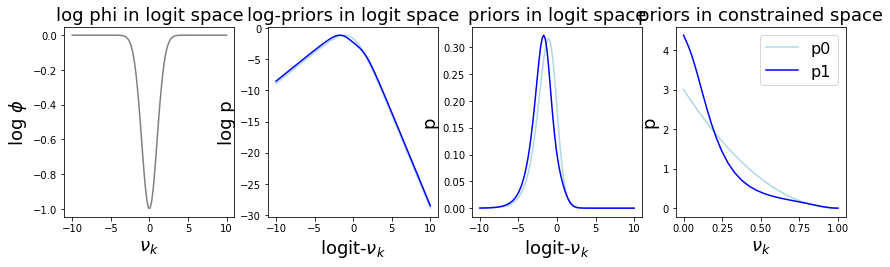

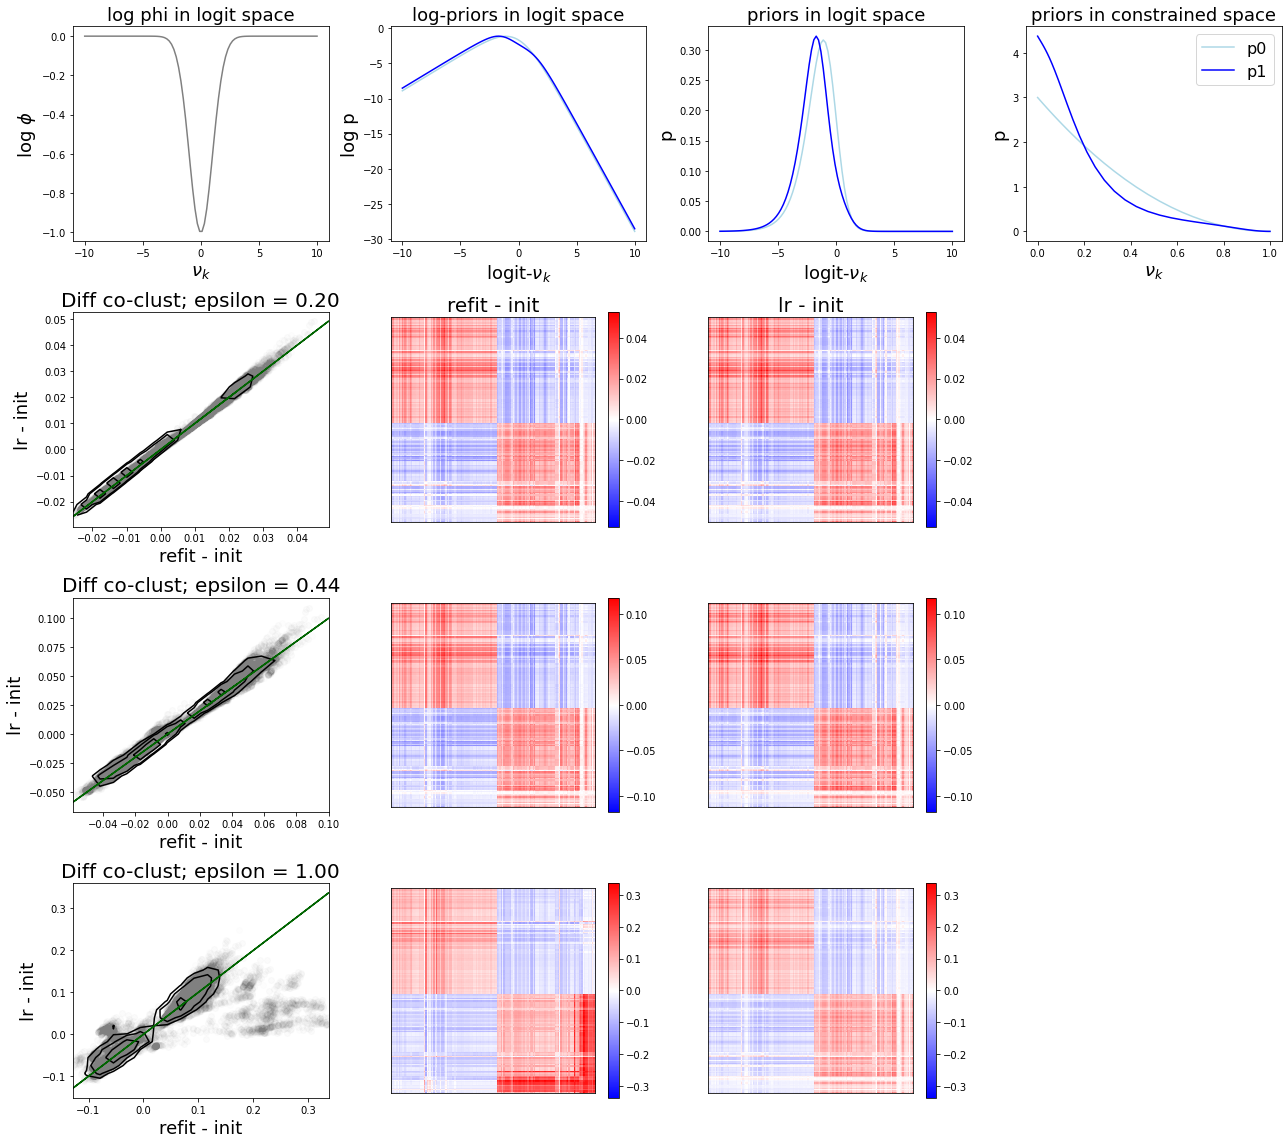

In [26]:
perturbation = 'gauss_pert1'
delta = -1
result_loading_utils.plot_perturbation(perturbation, delta, alpha0)
plot_results_for_perturbation(perturbation, delta, epsilon_indx_vec = [4, 6, -1])

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 3.565685e-07
  warnings.warn(


Optim time at epsilon = 1: 7.596secs
Derivative time: 0.712secs


/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 3.565685e-07
  warnings.warn(


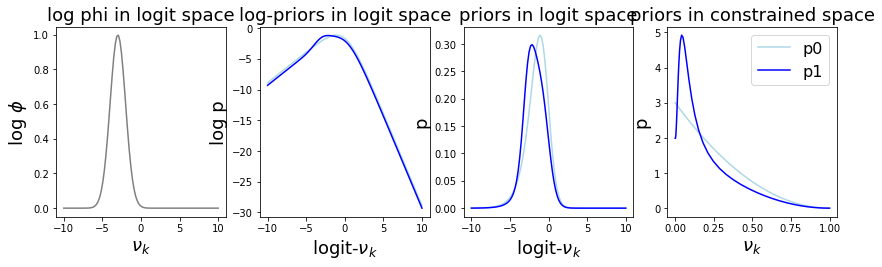

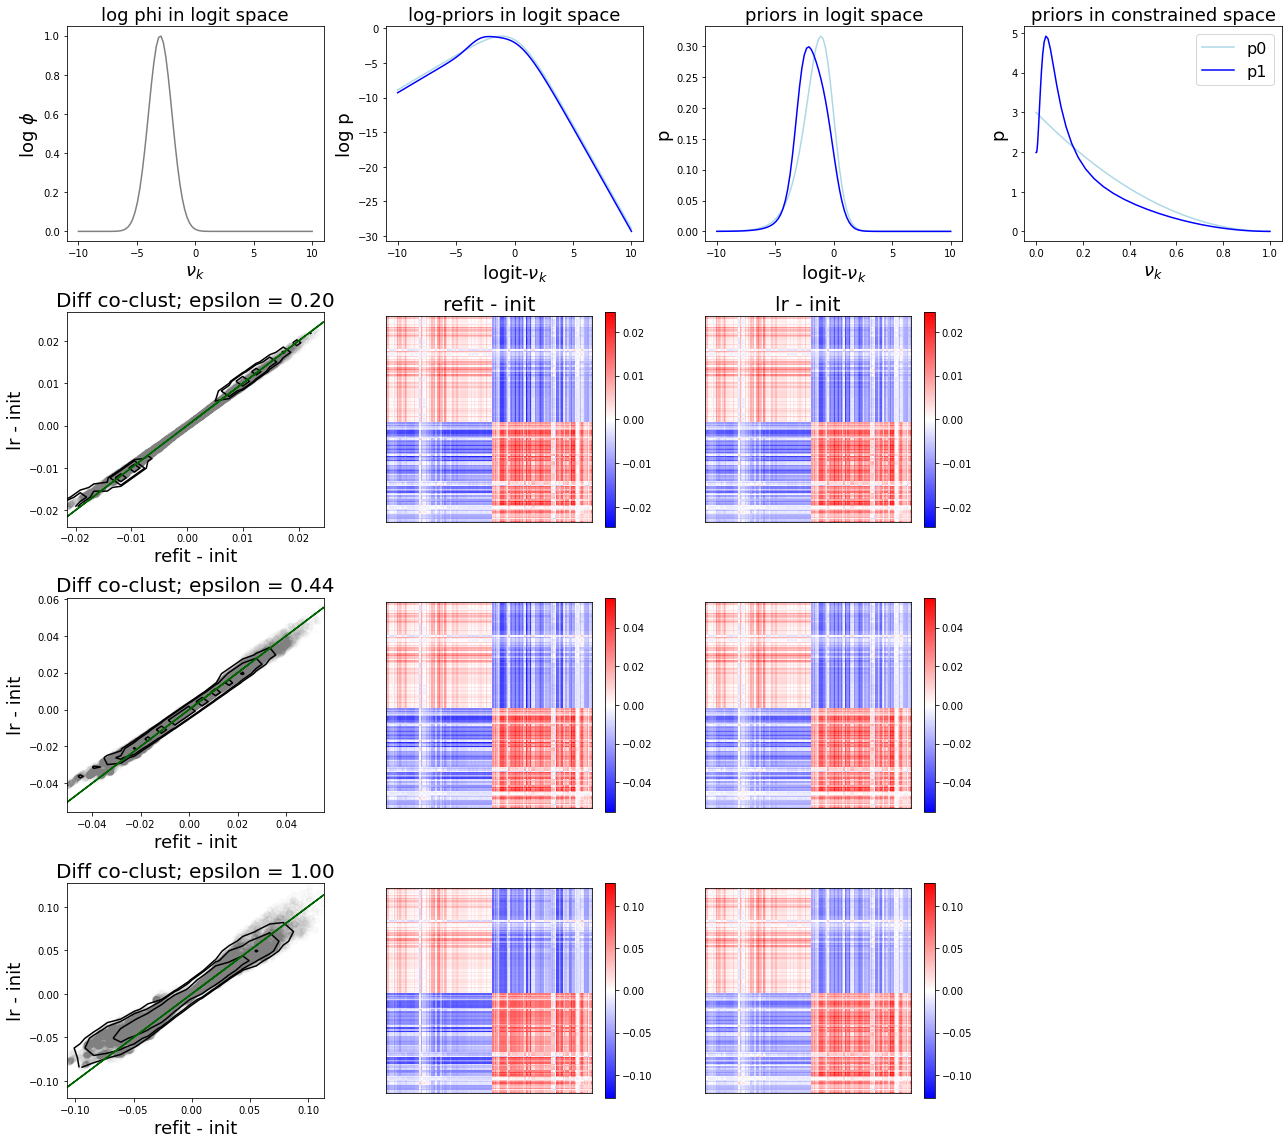

In [27]:
perturbation = 'gauss_pert2'
delta = 1
result_loading_utils.plot_perturbation(perturbation, delta, alpha0)
plot_results_for_perturbation(perturbation, delta, epsilon_indx_vec = [4, 6, -1])

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 2.349213e-08
  warnings.warn(


Optim time at epsilon = 1: 3.891secs
Derivative time: 0.712secs


/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 2.349213e-08
  warnings.warn(


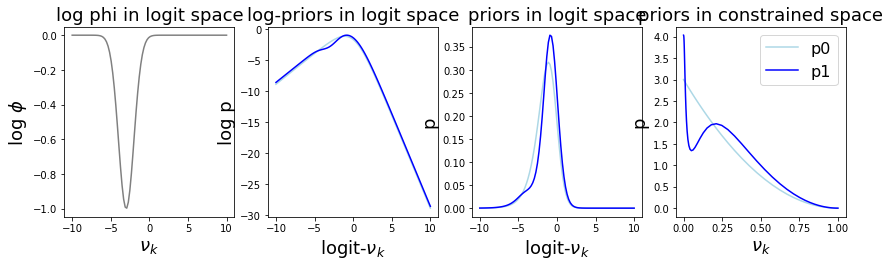

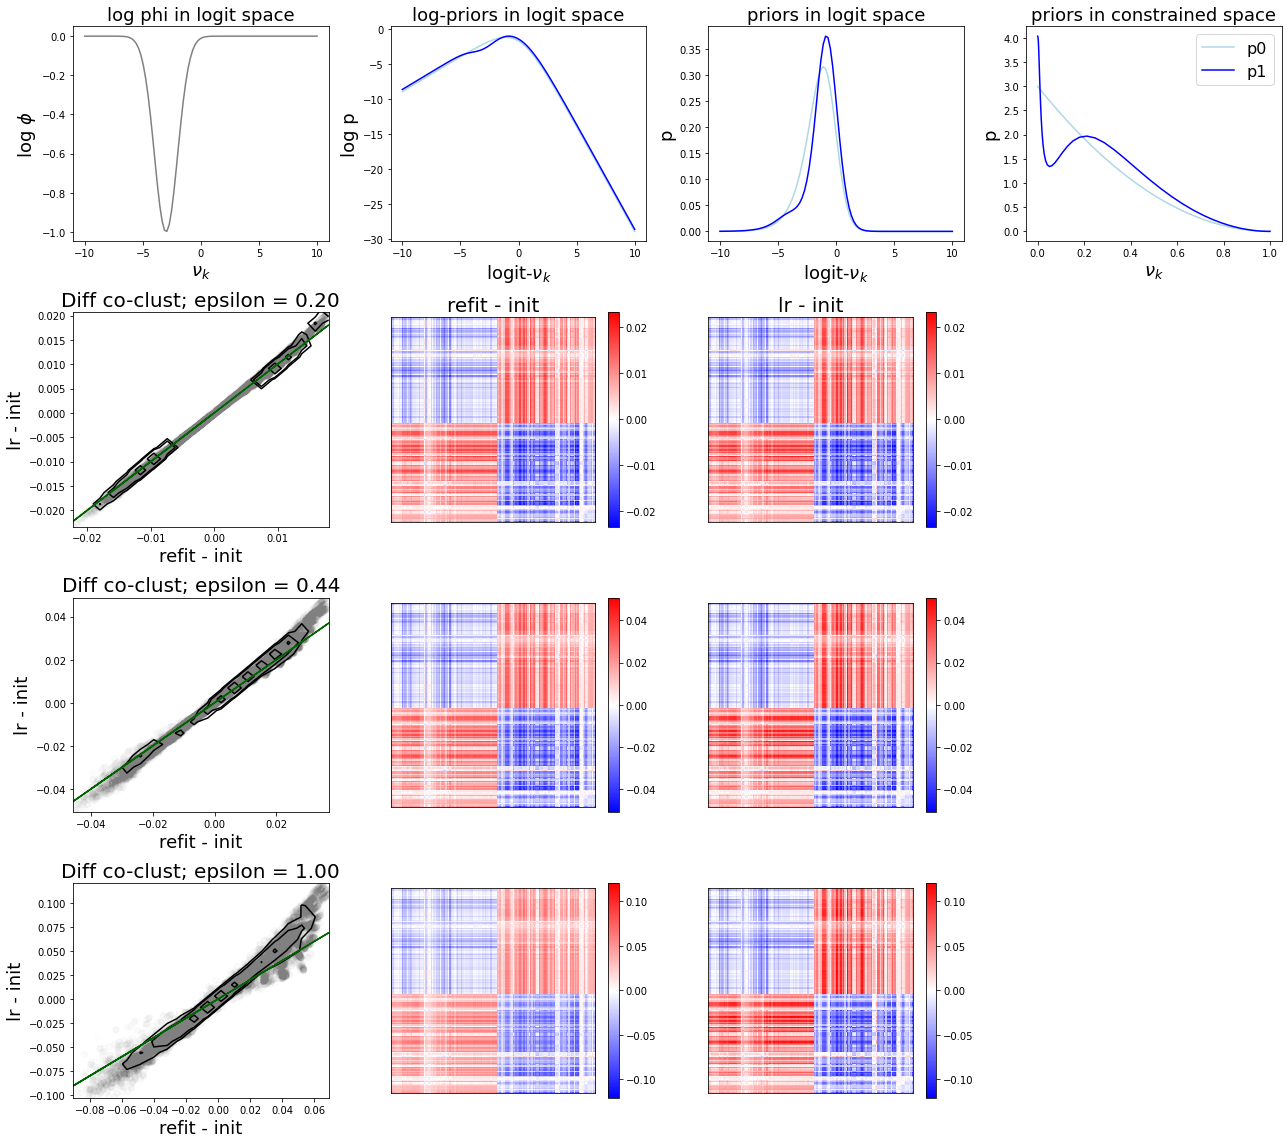

In [28]:
perturbation = 'gauss_pert2'
delta = -1
result_loading_utils.plot_perturbation(perturbation, delta, alpha0)
plot_results_for_perturbation(perturbation, delta, epsilon_indx_vec = [4, 6, -1])